In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
from copy import deepcopy
import joblib
from pprint import pprint
from math import ceil
import cortex
from neuro.config import repo_dir, PROCESSED_DIR, setup_freesurfer
from collections import defaultdict
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import gemv
from neuro.flatmaps_helper import load_flatmaps
import sasc.viz
from neuro import analyze_helper
from joblib import Memory

import nibabel as nib
neurosynth_compare = __import__('04_neurosynth_compare')
import neurosynth
from neuro.features.questions.gpt4 import QS_35_STABLE
import viz
setup_freesurfer()

subject = 'S02'
# subjects = [f'S0{i}' for i in range(1, 9) if not i == 6] # there's some problem with S06 surf2surf
subjects = ['S01', 'S02', 'S03']

# load flatmaps
d = defaultdict(list)
for subject in subjects:
    # if subject in ['S01', 'S02', 'S03']:
    # settings = ['individual_gpt4',
    # 'individual_gpt4_wordrate', 'shapley_35']
    # else:
    # settings = ['individual_gpt4_ndel=1_pc_new']
    settings = ['individual_gpt4_pc_new']
    flatmaps_qa_list = defaultdict(list)
    for setting in settings:
        flatmaps_qa_dict = joblib.load(
            join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
        for q in flatmaps_qa_dict.keys():
            flatmaps_qa_list[q].append(flatmaps_qa_dict[q])
    flatmaps_qa_dict = {
        q: np.mean(flatmaps_qa_list[q], axis=0)
        for q in flatmaps_qa_list.keys()
    }
    # for k in sorted(flatmaps_qa_dict.keys()):
    for k in QS_35_STABLE:
        # print(k, flatmaps_qa_dict[k])
        # d[f'q_{subject}'].append(k)
        d[subject].append(flatmaps_qa_dict[k])

    # print(subject, len(flatmaps_qa_dict))
df = pd.DataFrame(d)
# df.set_index('q_S01', inplace=True)
df.index = QS_35_STABLE
df.index.name = 'question'
df = df[df.index.isin(QS_35_STABLE)]
assert df.shape[0] == 35

In [ ]:
# # save mni vols
# mni_arrs_list = []
# for q in tqdm(df.index):
#     mni_vols = []
#     for subject in subjects:
#         print(subject)
#         subj_vol = cortex.Volume(df.loc[q][subject], 'UT' + subject,
#                                  xfmname=f"UT{subject}_auto")
#         mni_vol = neurosynth.subj_vol_to_mni_surf(subj_vol, subject)
#         mni_vols.append(deepcopy(mni_vol))
#         mni_arrs = [mni_vol.data for mni_vol in mni_vols]
#     mni_arrs_list.append(deepcopy(mni_arrs))
# joblib.dump(mni_arrs_list, 'intersubject/mni_arrs_list.pkl')

In [ ]:
memory = Memory(location="intersubject/mni_cache", verbose=0)


# load arrs for first 3 subjects
mni_arrs_list = joblib.load('intersubject/mni_arrs_list.pkl')
mni_arrs_list = [a[:3] for a in mni_arrs_list]
subjects = subjects[:3]


@memory.cache
def mni_arr_subj_arr_cachable(mni_arr, subject):
    mni_vol = cortex.Volume(mni_arr, "fsaverage", "atlas_2mm")
    subj_vol, subj_arr = neurosynth.mni_vol_to_subj_vol_surf(mni_vol, subject)
    return subj_arr


@memory.cache
def subj_arr_subj_arr_cachable(subj_arr, subject_input, subject_target):
    print('args', subj_arr.shape, subject_input, subject_target)
    subj_vol = cortex.Volume(subj_arr, subject='UT' + subject_input,
                             xfmname=f"UT{subject_input}_auto")
    return neurosynth.subj_vol_to_subj_surf(
        subj_vol, subject_input, subject_target)


# compute correlations
corrs_list = []
corrs_list_subj = []
corrs_list_subj_direct = []
for j, q in enumerate(df.index):
    # compute correlation between each one and mean of the others
    mni_arrs = np.array(mni_arrs_list[j])
    corrs_loo = []
    corrs_loo_subj = []
    corrs_loo_subj_direct = []
    for i, subj in enumerate(subjects):
        mni_arr = mni_arrs[i]
        subj_arr = df.loc[q][subj]
        other_mni_arrs = np.delete(mni_arrs, i, axis=0)
        mean_other_mni_arr = np.mean(other_mni_arrs, axis=0)

        # corr = np.corrcoef(mni_arr.flatten(),
        #                    mean_other_mni_arr.flatten())[0, 1]
        # print(f'mni corr between {i} and mean of others', corr)
        # corrs_loo.append(corr)

        mean_other_subj_arr = mni_arr_subj_arr_cachable(
            mean_other_mni_arr, subj)
        corr_subj = np.corrcoef(subj_arr.flatten(),
                                mean_other_subj_arr.flatten())[0, 1]
        print(f'subj corr between {i} and mean of others', corr_subj)
        corrs_loo_subj.append(corr_subj)

        other_subj_arrs = [
            subj_arr_subj_arr_cachable(
                df.loc[q][subj_input], subj_input, subject_target=subj)
            for subj_input in subjects if not subj_input == subj
        ]
        mean_other_subj_arr = np.mean(other_subj_arrs, axis=0)
        corr_subj_direct = np.corrcoef(subj_arr.flatten(),
                                       mean_other_subj_arr.flatten())[0, 1]
        print(
            f'subj dir corr between {i} and mean of others', corr_subj_direct)
        corrs_loo_subj_direct.append(corr_subj_direct)

    corrs_list.append(corrs_loo)
    corrs_list_subj.append(corrs_loo_subj)
    corrs_list_subj_direct.append(corrs_loo_subj_direct)

mean corr 0.27139411898456367
S01 corr 0.274257925654795
S02 corr 0.2911799283138964
S03 corr 0.2487445029849996


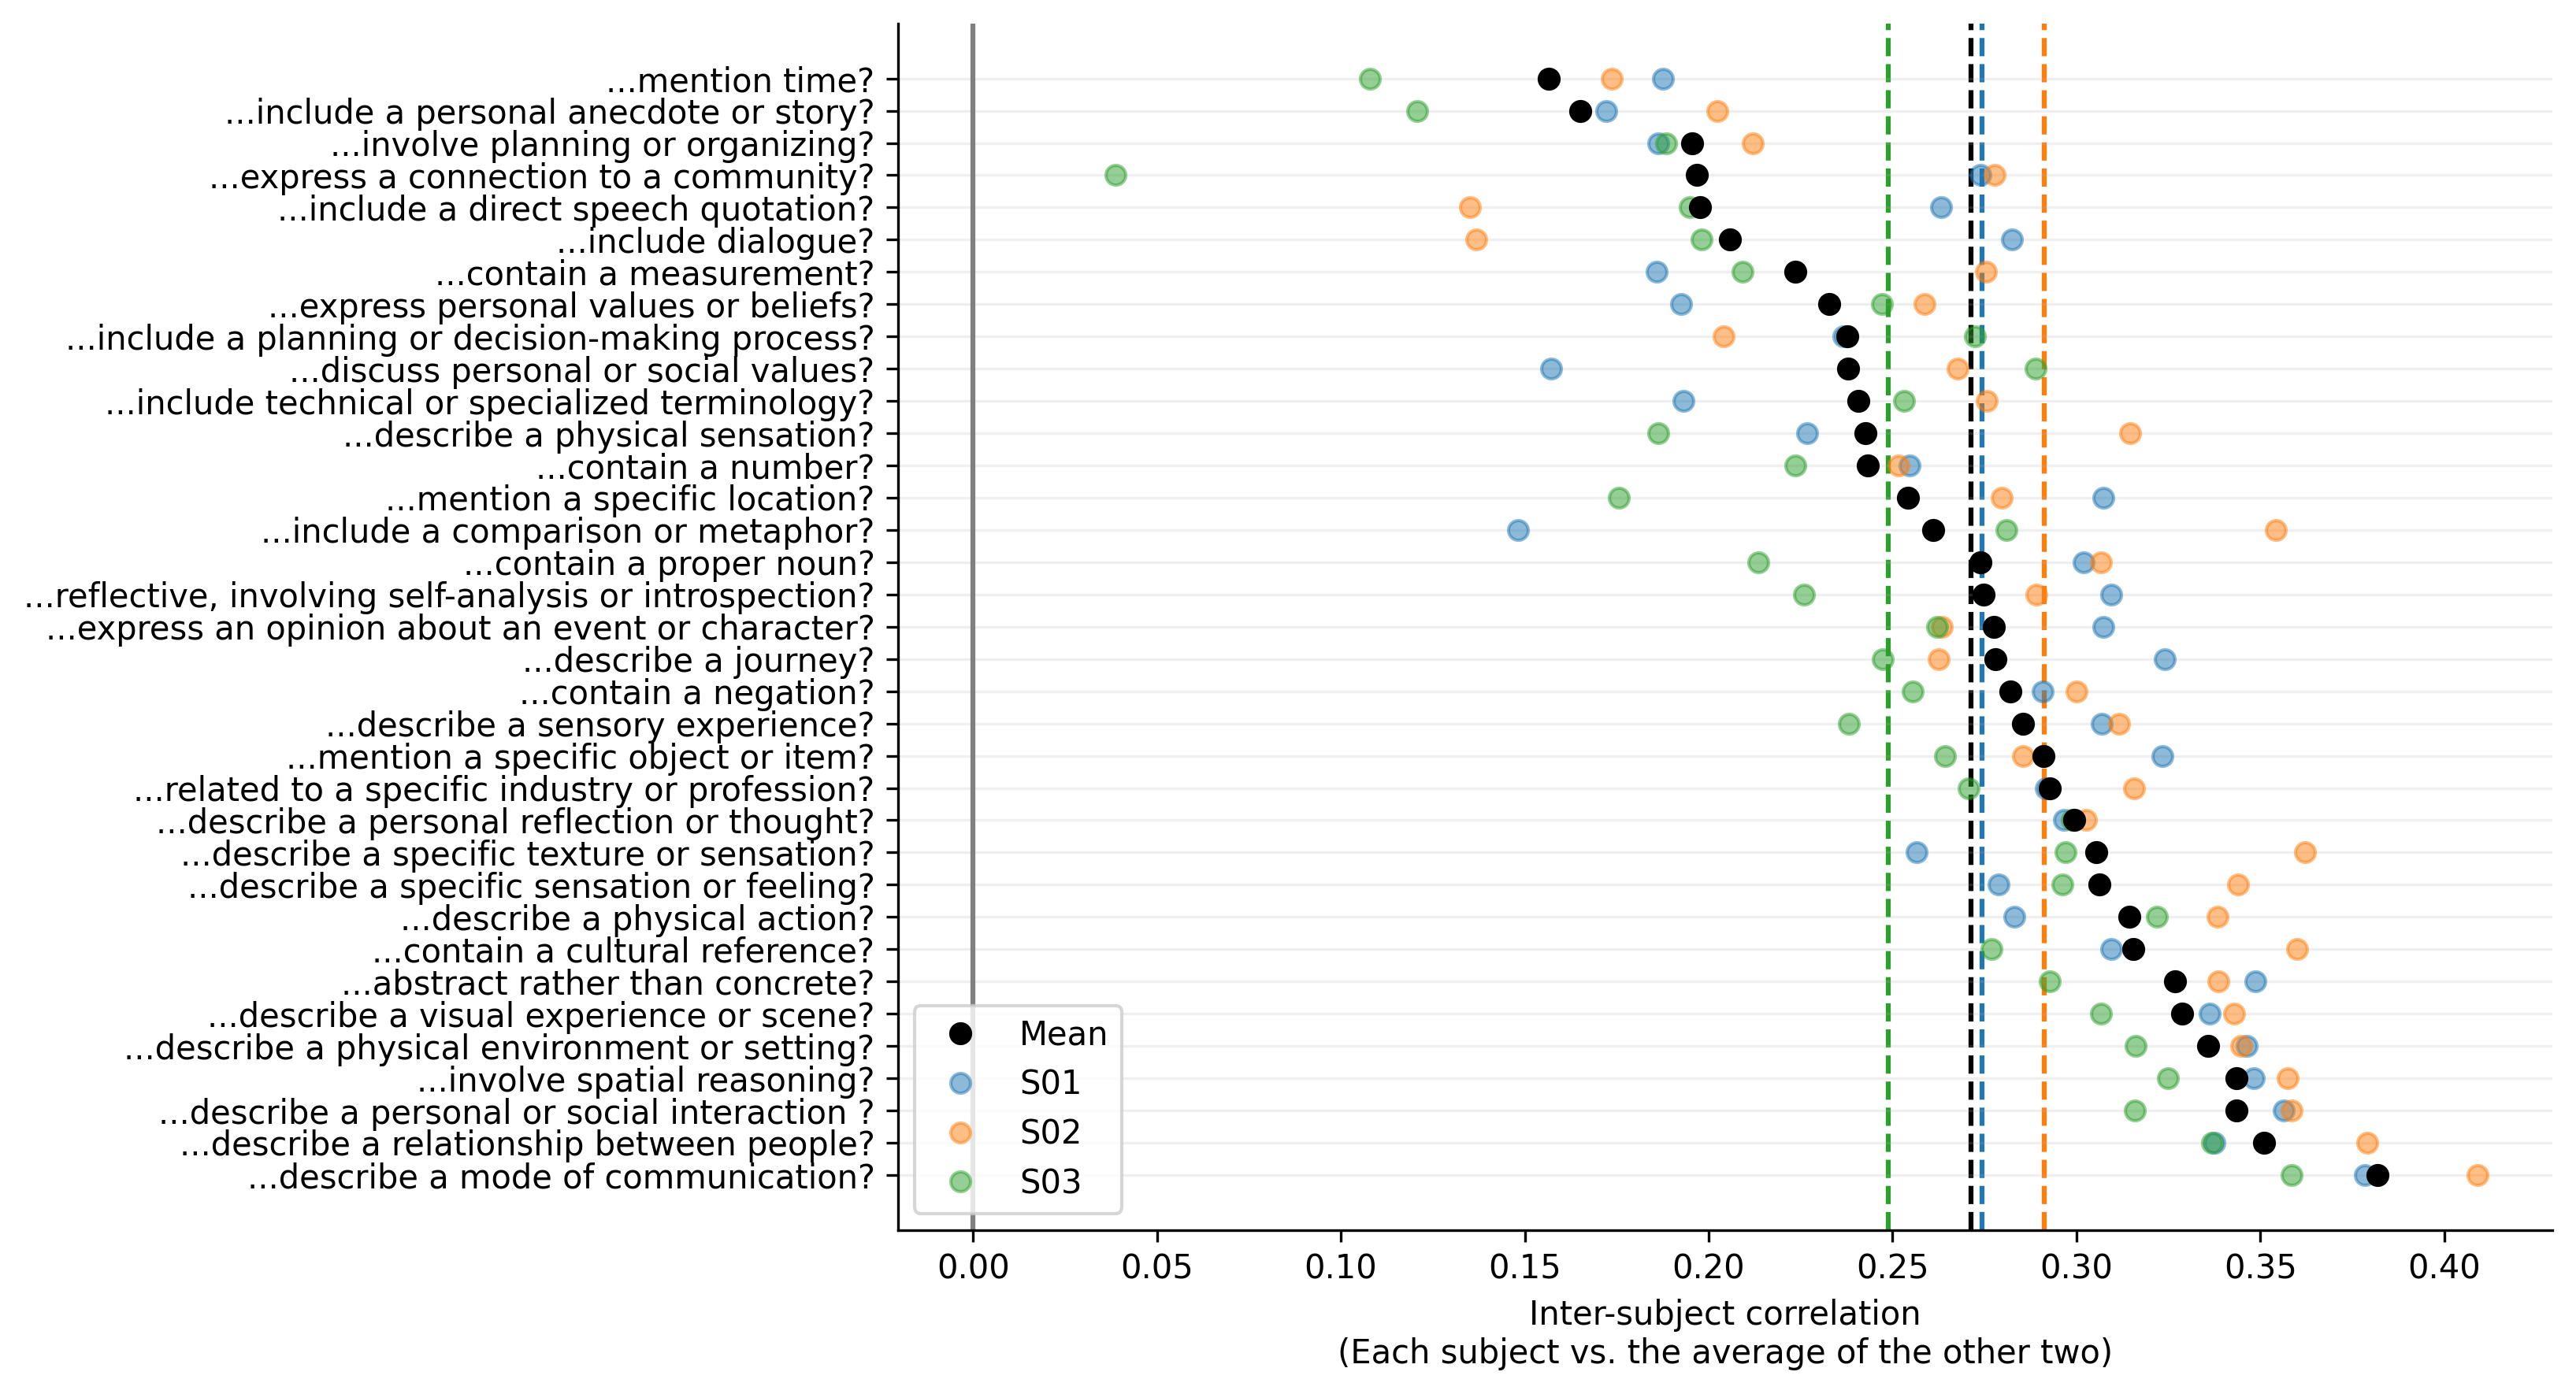

In [44]:
# corrs_df = pd.DataFrame(np.array(corrs_list), columns=subjects, index=df.index)
# corrs_df = pd.DataFrame(np.array(corrs_list_subj_direct),
# columns=subjects, index=df.index)
corrs_df = pd.DataFrame(np.array(corrs_list_subj),
                        columns=subjects, index=df.index)

# flatten with column name as value for a new column
corrs_df = corrs_df.melt(
    ignore_index=False, var_name='subject', value_name='corrs').reset_index()
corrs_df.rename(columns={'question': 'questions'}, inplace=True)

plt.figure(figsize=(11, 6), dpi=300)
neurosynth_compare.plot_corrs_df(
    corrs_df,
    out_dir='intersubject',
    plot_val=f'corrs',
    xlab=f'Inter-subject correlation\n(Each subject vs. the average of the other two)',
)
plt.show()

### statistical tests

In [ ]:
# baseline_distrs = []
# for i, subject in enumerate(tqdm(['UTS01', 'UTS02', 'UTS03'])):
#     flatmaps_qa_list = [arr[i].flatten() for arr in mni_arrs_list]
#     flatmaps_null = np.array(joblib.load(
#         join(PROCESSED_DIR,
#              #  subject.replace('UT', ''), 'resp_chunks_1trs.pkl')))
#              subject.replace('UT', ''), 'resp_chunks_1trs_MNI.pkl')))
#     # flatmaps_null = [arr.flatten() for arr in flatmaps_null]
#     flatmaps_null = flatmaps_null.reshape(flatmaps_null.shape[0], -1)

#     _, baseline_distr = viz.compute_pvals(
#         flatmaps_qa_list,
#         frac_voxels_to_keep=1,
#         corrs_gt_arr=corrs_df[f'corrs'].values,
#         flatmaps_null=flatmaps_null,
#     )

#     baseline_distrs.append(baseline_distr)
# joblib.dump(baseline_distrs, 'baseline_distrs.pkl')

In [ ]:
baseline_distrs = joblib.load('baseline_distrs.pkl')

In [ ]:
vals_baseline = np.array(baseline_distrs).mean(axis=0)
vals_alt = corrs_df[f'corrs'].values

n = len(vals_alt)
print(np.mean(vals_alt))

# permutation test on mean
n_samples = 1000
means_baseline = [
    np.mean(np.random.choice(vals_baseline.flatten(), size=n, replace=False))
    for i in range(n_samples)
]
print('mean test p', np.mean(np.array(means_baseline) >= np.mean(vals_alt)))

# permutation test on individuals
pvals = []
for i in range(len(vals_baseline)):
    pvals.append(np.mean(vals_baseline[i] >= vals_alt[i]))
pvals = multipletests(
    pvals, method='fdr_bh', alpha=0.05)[1]
print('individual pvals (err corrected)',
      pvals, 'num sig', np.sum(pvals < 0.05))

### Export mean mni arrs

In [ ]:
mni_arr_mean_dict = {
    k: np.mean(v, axis=0) for k, v in zip(df.index, mni_arrs_list)
}
joblib.dump(mni_arr_mean_dict, 'intersubject/mni_arr_mean_dict.pkl')